# Reconstruction with real data

In [1]:
%load_ext autoreload
%autoreload 2
import site
import sys
import time
site.addsitedir('..')
from jax.config import config

config.update("jax_enable_x64", True)

In [47]:
import numpy as np
import jax.numpy as jnp
from  matplotlib import pyplot as plt
from src.utils import *
from src.projection import project_spatial, project, rotate_z0
from src.interpolate import *
from src.jaxops import *
from src.fsc import *
from src.algorithm import *
from src.ab_initio import ab_initio, ab_initio_mcmc
from src.residual import get_volume_residual
import jax

import mrcfile

plt.rcParams["figure.figsize"]=6,6

### Read the data

In [3]:
#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/CaltechWeaver/"
#star_file = "job550_particles_subsamp5_10000_30_40_2.star"
#star_file = "job550_particles_roy40k.star"
#star_file = "job550_particles.star"


#data_dir = "/project/lederman/rrl28/share/cryoem_data/v3/Frost/eIF2B/job042/"
#star_file = "AUG11_99Kparticles_updatedGCTF.star"

#data_dir = "/project/lederman/rrl28/share/CryoEMDataSmall/RelionSample/relion30_tutorial_precalculated_results/"
#star_file = "Extract/job020/particles.star"

#data_dir = "/gpfs/gibbs/pi/lederman/dge5/RELION_TUTORIAL_SET/PrecalculatedResults/"
#star_file = "/Extract/job018/particles.star"

data_dir = "/gpfs/gibbs/pi/lederman/3DFSC_data/tilted/Particle-Stack/"
star_file = "T40_HA_130K-Equalized_run-data.star"

params0, imgs0 = load_data(data_dir, star_file, load_imgs = True, fourier = False)
ctf_params0 = params0["ctf_params"]
pixel_size0 = params0["pixel_size"]
angles0 = params0["angles"]
shifts0 = params0["shifts"]


/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:531: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_INDEX], df[UCSF.IMAGE_PATH] = \
/home/bt387/project/2021_CryoEMSolver7/external/pyem/pyem/star.py:539: FutureWarning: Columnar iteration over characters will be deprecated in future releases.
  df[UCSF.IMAGE_ORIGINAL_INDEX], df[UCSF.IMAGE_ORIGINAL_PATH] = \


load_data: number of partcles:  130000
load_data: data loaded, time:  64.66965436935425


In [4]:
print(imgs0.shape)
print(pixel_size0.shape)
print(angles0.shape)
print(shifts0.shape)
print(ctf_params0.shape)

#plt.imshow(np.abs(jnp.fft.fftshift(imgs_f0[101]))); plt.colorbar()

(130000, 256, 256)
(130000,)
(130000, 3)
(130000, 2)
(130000, 9)


### Only keep N points at random (to avoid out of memory error)

In [5]:
N = 5000 # imgs0.shape[0]
idxrand = np.random.permutation(130000)[:N]

imgs0 = imgs0[idxrand]
pixel_size = pixel_size0[idxrand]
angles = angles0[idxrand]
shifts = shifts0[idxrand]
ctf_params = ctf_params0[idxrand]

### Some angle filtering

In [6]:
#idx = jnp.abs(angles0[:,2]) < jnp.pi/4
#imgs_f = imgs_f0[idx]
#pixel_size = pixel_size0[idx]
#angles = angles0[idx]
#shifts = shifts0[idx]
#ctf_params = ctf_params0[idx]

#idx2 = jnp.abs(angles[:,1]) < jnp.pi/3
#imgs_f = imgs_f[idx2]
#pixel_size = pixel_size[idx2]
#angles = angles[idx2]
#shifts = shifts[idx2]
#ctf_params = ctf_params[idx2]

#plot_angles(angles)

### Take the FFT of the images

In [7]:
t0 = time.time()
imgs_f = np.array([np.fft.fft2(np.fft.ifftshift(img)) for img in imgs0])
print(time.time()-t0)

9.605077505111694


### Create the grids

In [8]:
# Assume the pixel size is the same for all images
nx = imgs_f.shape[-1]
px = pixel_size[0]
N = imgs_f.shape[0]

x_grid = create_grid(nx, px)
y_grid = x_grid
z_grid = x_grid
print(x_grid)

[2.981875e-03 2.560000e+02]


### Crop images to 32 x 32 

In [9]:
nx = 64
imgs_f, x_grid = crop_fourier_images(imgs_f, x_grid, nx)

y_grid = x_grid
z_grid = x_grid
print(x_grid)

[2.981875e-03 6.400000e+01]


### Before further processing, vectorize the images, create mask etc

In [10]:
imgs_f = imgs_f.reshape(N, -1)
print(imgs_f.shape)

(5000, 4096)


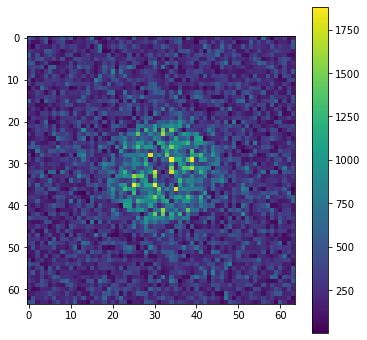

In [11]:
plt.imshow(np.abs(jnp.fft.fftshift(imgs_f[101].reshape(nx,nx)))); plt.colorbar()

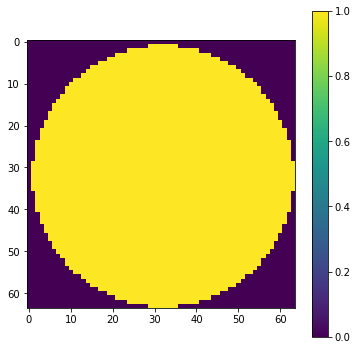

In [12]:
centre = (0,0,0)
#radius = 0.045 # for nx=32
radius = 0.093 # nx-64
#radius = 0.07 # for nx=64
#radius = 0.14 # for nx=128
#radius = 0.28 # for nx=256

mask = create_3d_mask(x_grid, centre, radius)

mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

### Estimate the noise

First, decide on the dimensions of the empty corners to use for noise estimation:

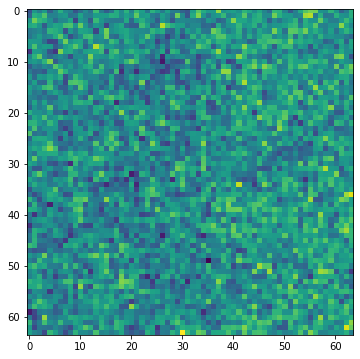

In [13]:
N_noise = 64
plt.imshow(jnp.mean(imgs0[:,:N_noise,:N_noise], axis=0))

Only use a small subset of the data for noise estimation so the kernel doesn't crash (possibly due to running out of memory)

Text(0.5, 1.0, 'Estimated noise')

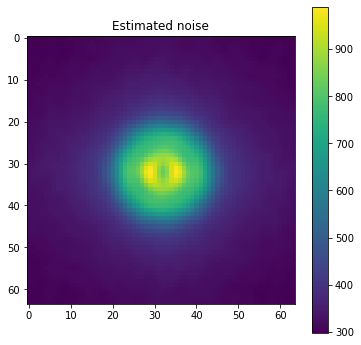

In [14]:
sigma_noise_estimated = estimate_noise_imgs(imgs0[:5000], nx_empty = N_noise, nx_final = nx).reshape([nx,nx])
plt.imshow(jnp.fft.fftshift(sigma_noise_estimated)); plt.colorbar()
plt.title('Estimated noise')

#### A quadratic noise model, fitted on the estimated one, for fun

Text(0.5, 1.0, 'Quadratic noise approximation')

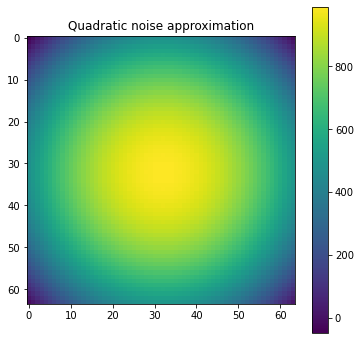

In [15]:
x_freq = jnp.fft.fftfreq(x_grid[1].astype(np.int64), 1/(x_grid[1] * x_grid[0]))
X,Y = jnp.meshgrid(x_freq, x_freq)
C = (jnp.max(sigma_noise_estimated)-jnp.min(sigma_noise_estimated))*1.5/jnp.max(X**2+Y**2)
sigma_noise_quadratic = jnp.max(sigma_noise_estimated) -(X**2 + Y**2)* C 
plt.imshow(jnp.fft.fftshift(sigma_noise_quadratic)); plt.colorbar()
plt.title('Quadratic noise approximation')

#### Average radially

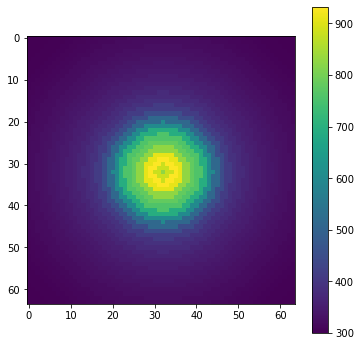

In [16]:
sigma_noise_avg = average_radially(sigma_noise_estimated, x_grid)

plt.imshow(jnp.fft.fftshift(sigma_noise_avg)); plt.colorbar()

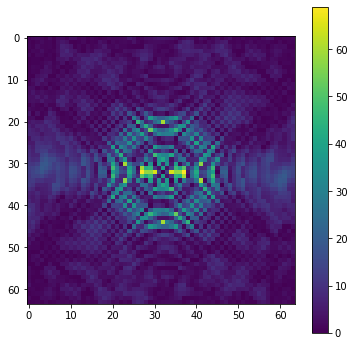

In [17]:
plt.imshow(jnp.fft.fftshift(jnp.abs(sigma_noise_avg-sigma_noise_estimated))); plt.colorbar()

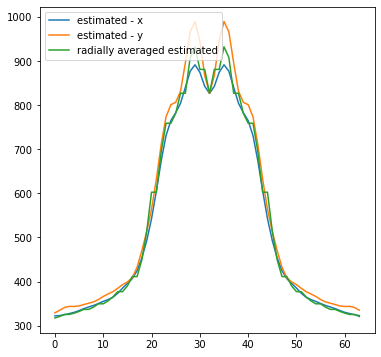

In [18]:
plt.plot(jnp.fft.fftshift(sigma_noise_estimated[:,0]))
plt.plot(jnp.fft.fftshift(sigma_noise_estimated[0,:]))
#plt.plot(jnp.fft.fftshift(sigma_noise_quadratic[:,0]))
plt.plot(jnp.fft.fftshift(sigma_noise_avg[:,0]))
#plt.legend(['estimated - x', 'estimated - y', 'quadratic', 'radially averaged estimated'])
plt.legend(['estimated - x', 'estimated - y', 'radially averaged estimated'])

In [19]:
sigma_noise = sigma_noise_avg.reshape(-1)

### Delete the real images
Since we only work with the Fourier ones from now on.

In [20]:
del(imgs0)
#del(imgs)

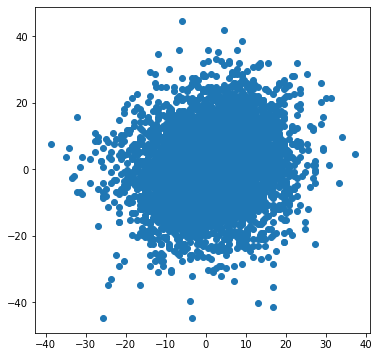

In [21]:
plt.scatter(shifts[:,0], shifts[:,1])

### Ab initio

In [22]:
type(imgs_f)

numpy.ndarray

In [23]:
#old_stdout = sys.stdout
#sys.stdout = open('../data/relion/output.txt', 'w')

In [24]:
#sys.stdout = sys.__stdout__

In [25]:
#v_rec_int = v_rec
#angles_rec_int = angles_rec

Fourier radius: 0.04771
Starting radius: 0.01
Frequency marching step size: 0.005164759001819446
Number of frequency marching steps: 8
------------------------------------

Initialitsing volume
  sgd epoch 0: mean gradient = 2.2853331550485636e-07
  sgd epoch 10: mean gradient = 5.715908947603321e-08
  sgd epoch 20: mean gradient = 1.5985882909215162e-07
  sgd epoch 30: mean gradient = 1.8058509382139863e-08


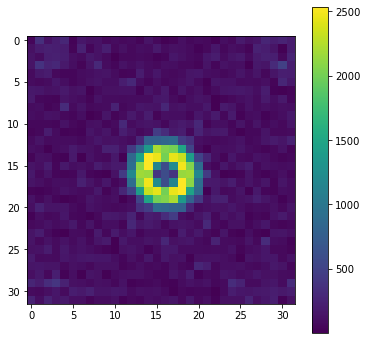

Iter  0
  MC sample 20 , loss = 17.569391681344744
  MC sample 40 , loss = 17.562294621050235
  MC sample 60 , loss = 17.579859621588735
  MC sample 80 , loss = 17.574402707938003
  MC sample 100 , loss = 17.56752904286036
  MC sample 120 , loss = 17.57520387397253
  MC sample 140 , loss = 17.578744717784478
  MC sample 160 , loss = 17.576540430515067
  MC sample 180 , loss = 17.57790745053784
  MC sample 200 , loss = 17.579717072754956
  MC sample 220 , loss = 17.57451692430842
  MC sample 240 , loss = 17.57543977614091
  MC sample 260 , loss = 17.584321205068917
  MC sample 280 , loss = 17.576785364280408
  MC sample 300 , loss = 17.57037166044027
  MC sample 320 , loss = 17.56903071159958
  MC sample 340 , loss = 17.57430508122854
  MC sample 360 , loss = 17.57649212218884
  MC sample 380 , loss = 17.581046178944852
  MC sample 400 , loss = 17.58565573496985
  MC sample 420 , loss = 17.568289565707563
  MC sample 440 , loss = 17.56681978595571
  MC sample 460 , loss = 17.57806636142

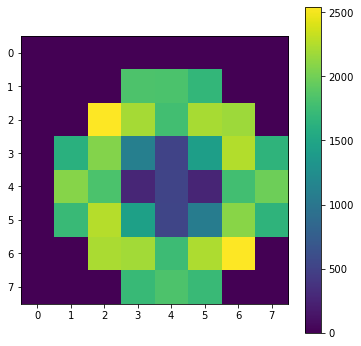

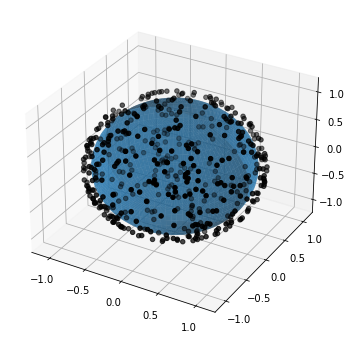

Iter  1
  MC sample 20 , loss = 43.75444251606054
  MC sample 40 , loss = 43.763836495298996
  MC sample 60 , loss = 43.751430061402836
  MC sample 80 , loss = 43.752453979210756
  MC sample 100 , loss = 43.74721615107654
  MC sample 120 , loss = 43.75480531084997
  MC sample 140 , loss = 43.76133070890668
  MC sample 160 , loss = 43.7579037758079
  MC sample 180 , loss = 43.74588850301496
  MC sample 200 , loss = 43.759443740136156
  MC sample 220 , loss = 43.75040150092722
  MC sample 240 , loss = 43.75957733512267
  MC sample 260 , loss = 43.75119414628516
  MC sample 280 , loss = 43.759266997333064
  MC sample 300 , loss = 43.76645746055117
  MC sample 320 , loss = 43.75282289611674
  MC sample 340 , loss = 43.756487666273095
  MC sample 360 , loss = 43.75253440309126
  MC sample 380 , loss = 43.7579626524638
  MC sample 400 , loss = 43.75119278856063
  MC sample 420 , loss = 43.75569151065844
  MC sample 440 , loss = 43.75631888563392
  MC sample 460 , loss = 43.76082753769032
  M

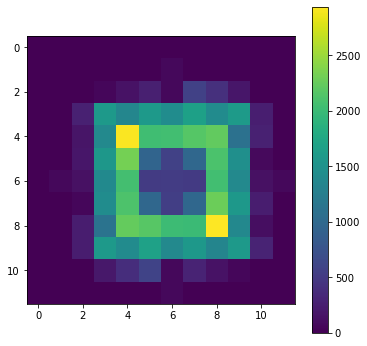

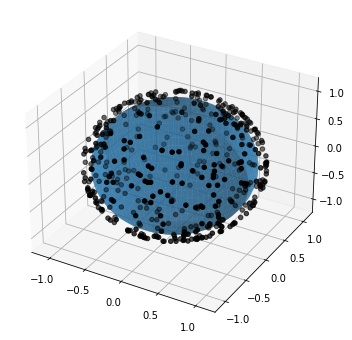

Iter  9
  MC sample 20 , loss = 70.37791759832558
  MC sample 40 , loss = 70.35454873518721
  MC sample 60 , loss = 70.3672175218895
  MC sample 80 , loss = 70.35497578057388
  MC sample 100 , loss = 70.38853937199018
  MC sample 120 , loss = 70.38232659623495
  MC sample 140 , loss = 70.34890659153827
  MC sample 160 , loss = 70.3499897998924
  MC sample 180 , loss = 70.35444723654646
  MC sample 200 , loss = 70.36757160625436
  MC sample 220 , loss = 70.35583212674628
  MC sample 240 , loss = 70.33960550932214
  MC sample 260 , loss = 70.33001517509518
  MC sample 280 , loss = 70.34901636150775
  MC sample 300 , loss = 70.3334815070395
  MC sample 320 , loss = 70.33762818357611
  MC sample 340 , loss = 70.32328849996311
  MC sample 360 , loss = 70.34048534911834
  MC sample 380 , loss = 70.324489044158
  MC sample 400 , loss = 70.34692333675466
  MC sample 420 , loss = 70.36926963508935
  MC sample 440 , loss = 70.3446832133996
  MC sample 460 , loss = 70.345693324209
  MC sample 480

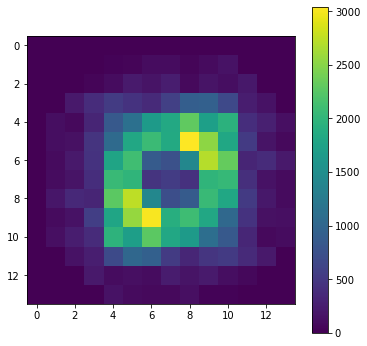

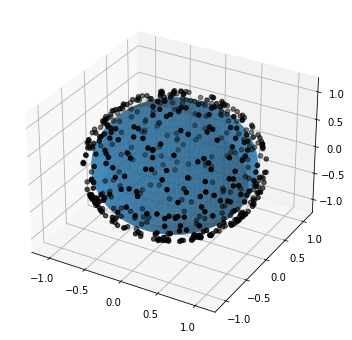

Iter  17
  MC sample 20 , loss = 118.90660389167786
  MC sample 40 , loss = 118.9297916704747
  MC sample 60 , loss = 118.88818919121887
  MC sample 80 , loss = 118.91301577244876
  MC sample 100 , loss = 118.89576338697884
  MC sample 120 , loss = 118.87644423684495
  MC sample 140 , loss = 118.89548958194368
  MC sample 160 , loss = 118.85878213386115
  MC sample 180 , loss = 118.84848106613649
  MC sample 200 , loss = 118.85228491925845
  MC sample 220 , loss = 118.85306210141266
  MC sample 240 , loss = 118.86893859232805
  MC sample 260 , loss = 118.87137237478258
  MC sample 280 , loss = 118.86849388519573
  MC sample 300 , loss = 118.86262322966908
  MC sample 320 , loss = 118.86203809343498
  MC sample 340 , loss = 118.86295651873483
  MC sample 360 , loss = 118.81212617601527
  MC sample 380 , loss = 118.85406749104983
  MC sample 400 , loss = 118.82739496935623
  MC sample 420 , loss = 118.81671309973258
  MC sample 440 , loss = 118.82447562086112
  MC sample 460 , loss = 118

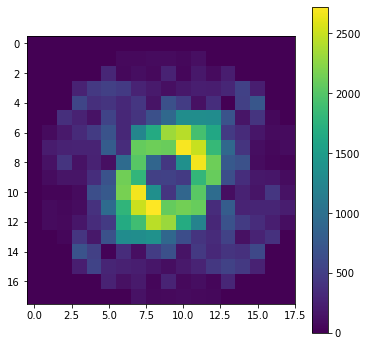

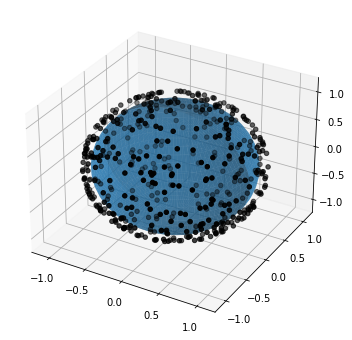

Iter  25
  MC sample 20 , loss = 171.50131364126247
  MC sample 40 , loss = 171.49744975883928
  MC sample 60 , loss = 171.46422883262875
  MC sample 80 , loss = 171.47096917821074
  MC sample 100 , loss = 171.47375960295656
  MC sample 120 , loss = 171.4642015957431
  MC sample 140 , loss = 171.47483531228326
  MC sample 160 , loss = 171.49393154309396
  MC sample 180 , loss = 171.4756491019396
  MC sample 200 , loss = 171.4809228785469
  MC sample 220 , loss = 171.48921301442368
  MC sample 240 , loss = 171.49209836214897
  MC sample 260 , loss = 171.4831971765194
  MC sample 280 , loss = 171.45307395262617
  MC sample 300 , loss = 171.47460681138105
  MC sample 320 , loss = 171.48536490162527
  MC sample 340 , loss = 171.48942054661075
  MC sample 360 , loss = 171.46937188834445
  MC sample 380 , loss = 171.45440313201576
  MC sample 400 , loss = 171.46832398014573
  MC sample 420 , loss = 171.47224224647917
  MC sample 440 , loss = 171.46724079155663
  MC sample 460 , loss = 171.45

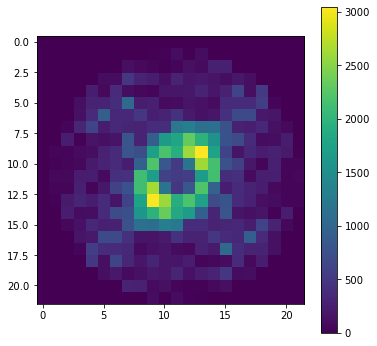

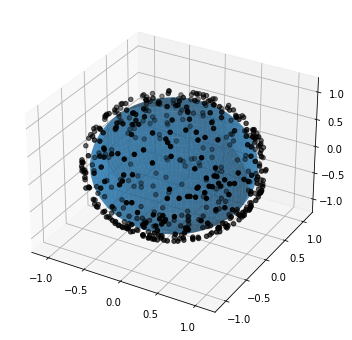

Iter  33
  MC sample 20 , loss = 221.06839160240196
  MC sample 40 , loss = 221.05719353134467
  MC sample 60 , loss = 221.05412358593605
  MC sample 80 , loss = 221.07565544221896
  MC sample 100 , loss = 221.0845755591335
  MC sample 120 , loss = 221.0696176504913
  MC sample 140 , loss = 221.08838189705003
  MC sample 160 , loss = 221.08752319136923
  MC sample 180 , loss = 221.08517397466173
  MC sample 200 , loss = 221.0905163643052
  MC sample 220 , loss = 221.10448932112192
  MC sample 240 , loss = 221.0920993049835
  MC sample 260 , loss = 221.10970734464956
  MC sample 280 , loss = 221.1238757427134
  MC sample 300 , loss = 221.1278779265562
  MC sample 320 , loss = 221.1375801587319
  MC sample 340 , loss = 221.14560810035627
  MC sample 360 , loss = 221.13255393366916
  MC sample 380 , loss = 221.13563512322443
  MC sample 400 , loss = 221.1112071122222
  MC sample 420 , loss = 221.10710382838985
  MC sample 440 , loss = 221.12004234535118
  MC sample 460 , loss = 221.121835

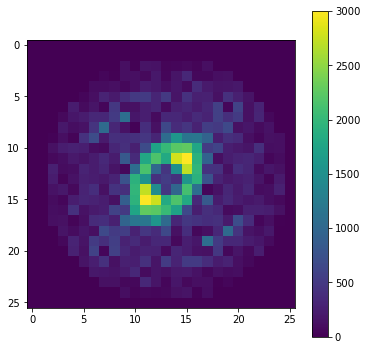

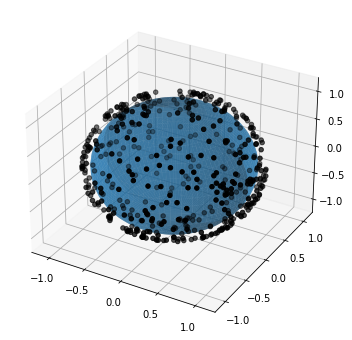

Iter  41
  MC sample 20 , loss = 292.16228880553496
  MC sample 40 , loss = 292.1581866445929
  MC sample 60 , loss = 292.16029536342205
  MC sample 80 , loss = 292.15742917800856
  MC sample 100 , loss = 292.16254120290097
  MC sample 120 , loss = 292.1700458092358
  MC sample 140 , loss = 292.16516849693744
  MC sample 160 , loss = 292.17000984016624
  MC sample 180 , loss = 292.1646251317097
  MC sample 200 , loss = 292.16384827654855
  MC sample 220 , loss = 292.19825401456444
  MC sample 240 , loss = 292.18273067251994
  MC sample 260 , loss = 292.1841296747273
  MC sample 280 , loss = 292.19327516579636
  MC sample 300 , loss = 292.1813137580976
  MC sample 320 , loss = 292.1928827922836
  MC sample 340 , loss = 292.1898210976081
  MC sample 360 , loss = 292.2095520919513
  MC sample 380 , loss = 292.21516521295405
  MC sample 400 , loss = 292.1962810819516
  MC sample 420 , loss = 292.1942601921765
  MC sample 440 , loss = 292.2079696641064
  MC sample 460 , loss = 292.205378922

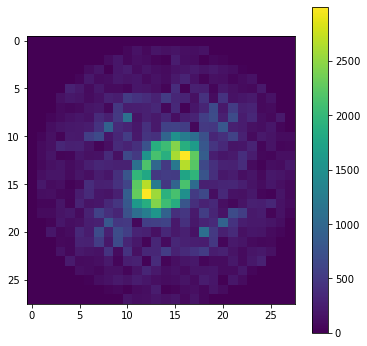

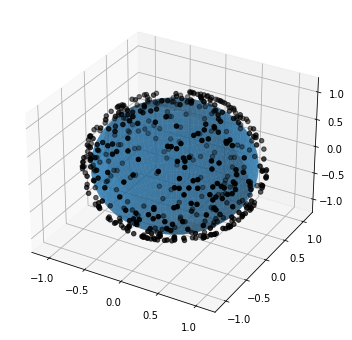

Iter  49
  MC sample 20 , loss = 360.4934495305452
  MC sample 40 , loss = 360.49726833118194
  MC sample 60 , loss = 360.494362466338
  MC sample 80 , loss = 360.49504798052305
  MC sample 100 , loss = 360.50154554127636
  MC sample 120 , loss = 360.5082560782608
  MC sample 140 , loss = 360.51047059526064
  MC sample 160 , loss = 360.5191775166784
  MC sample 180 , loss = 360.51372140751755
  MC sample 200 , loss = 360.5201140557638
  MC sample 220 , loss = 360.5149370681065
  MC sample 240 , loss = 360.5245782995763
  MC sample 260 , loss = 360.5299511384966
  MC sample 280 , loss = 360.52542149635684
  MC sample 300 , loss = 360.51949835713464
  MC sample 320 , loss = 360.5221132767228
  MC sample 340 , loss = 360.5304013627134
  MC sample 360 , loss = 360.5351658855402
  MC sample 380 , loss = 360.5422645690116
  MC sample 400 , loss = 360.5366807717035
  MC sample 420 , loss = 360.545423465793
  MC sample 440 , loss = 360.5367043084117
  MC sample 460 , loss = 360.54970675095063


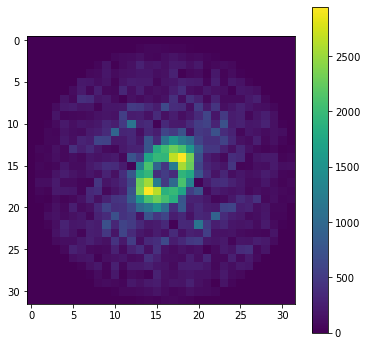

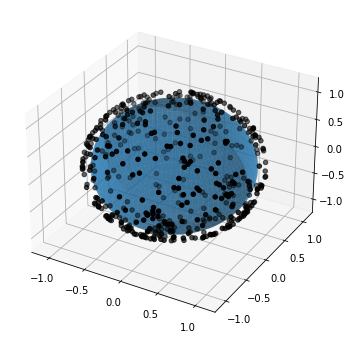

In [98]:
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))


# The number of iterations desn't matter, 
# since it stops when the volume is nx x nx x nx.
N_samples = 40000
N_iter = 1000000


radius0 = 0.01
#radius0 = 0.03
alpha = 1e-9  # <--- this is the working one
#alpha = 1e-6

# The number of cg or sgd iterations also doesn't matter,
# since it stops when it reaches the desired accuracy.
N_cg_iter = 100000
eps_cg = 3e-5

N_sgd_iter = 100000
batch_size = 300
learning_rate = 1e6
#learning_rate = 1
eps_gd = 1e-8 
eps_gd = 2e-8
P = None

use_sgd = True

if use_sgd:
    N_vol_iter = N_sgd_iter
    eps_vol = eps_gd
else:
    N_vol_iter = N_cg_iter
    eps_vol = eps_cg

N_samples_angles = 1000 #21 #100
N_samples_vol = 21    

# HMC params
#dt = 5
dt_list = jnp.array([0.1, 0.5, 1, 5, 10])
L = 5

vol0 = None
angles0 = None
#sigma_noise = jnp.ones(sigma_noise.shape)
    
out_dir = '../data/3dfsc/'
imgs_f = imgs_f.reshape([N, nx*nx])

opt_vol_first = True

#v_rec, angles_rec = ab_initio(project, imgs_f, sigma_noise, shifts, ctf_params, x_grid, use_sgd, N_iter, N_vol_iter, learning_rate, batch_size, P, N_samples, radius0, None, alpha, eps_vol, 'tri', True, True, True, out_dir)
v_rec, angles_rec, angles_samples, angles_r, v_samples, v_r = ab_initio_mcmc(key, project, imgs_f, sigma_noise, shifts, ctf_params, x_grid, use_sgd, vol0, angles0, N_iter, learning_rate, batch_size, P, N_samples_angles, N_samples_vol, dt_list, L, radius0, None, alpha, eps_vol, 'tri', opt_vol_first, True, True, out_dir)



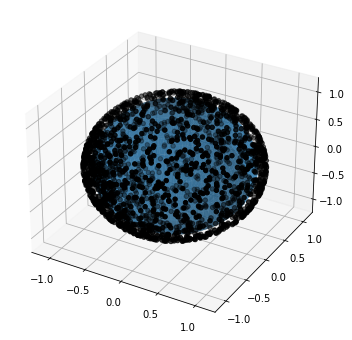

In [97]:
plot_angles(angles_rec[:2000])

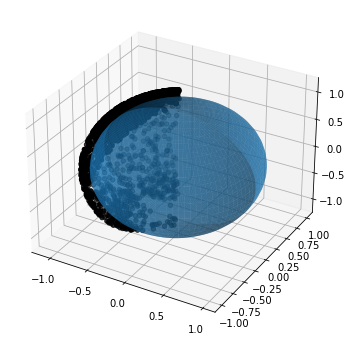

In [28]:
plot_angles(angles[:2000])

In [237]:
angles_r.shape

(999, 10000)

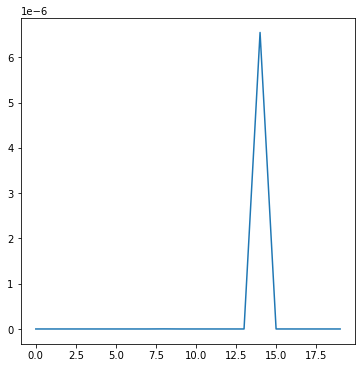

In [32]:
plt.plot(angles_r[:,100])

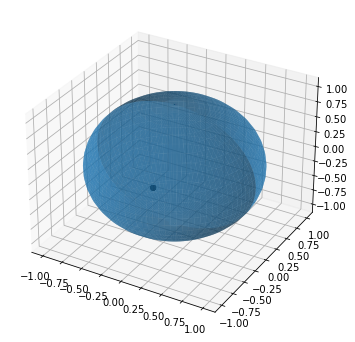

In [33]:
ae = angles_samples[:,3993,:]
ae.shape
plot_angles(ae)

In [67]:
angles_samples.shape

(999, 10000, 3)

In [225]:
angles_samples[:,3993,:]

DeviceArray([[1.3157887 , 2.47968212, 0.91884977],
             [1.3157887 , 2.47968212, 0.91884977],
             [1.3157887 , 2.47968212, 0.91884977],
             ...,
             [0.13064206, 0.97276588, 5.47910001],
             [0.13064206, 0.97276588, 5.47910001],
             [0.13064206, 0.97276588, 5.47910001]], dtype=float64)

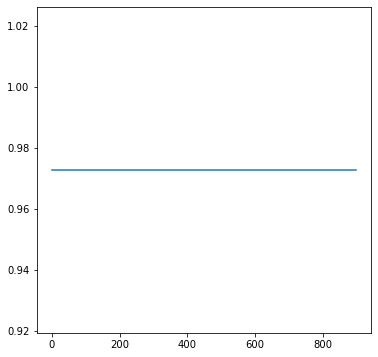

In [229]:
plt.plot(ae[100:,1])

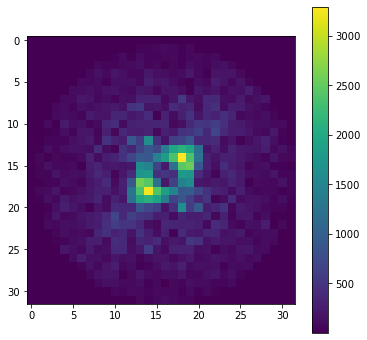

In [34]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_samples[0,:,:,0]))); plt.colorbar()

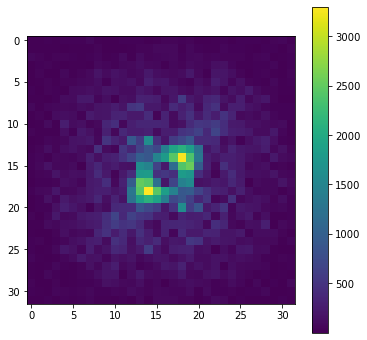

In [35]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_samples[20,:,:,0]))); plt.colorbar()

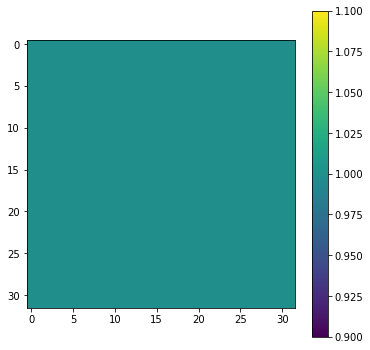

In [36]:
plt.imshow(jnp.abs(jnp.fft.fftshift(mask[:,:,0]))); plt.colorbar()

### Compare orientations

In [107]:
get_rot_mat = lambda a : get_rotation_matrix(a[0], a[1], a[2])

In [108]:
M = jax.vmap(get_rot_mat, in_axes=0)(angles)
M_rec = jax.vmap(get_rot_mat, in_axes=0)(angles_rec)

In [109]:
# C3 symmetry rotations:
C1 = get_rotation_matrix(0,0,2*jnp.pi/3)
C2 = get_rotation_matrix(0,0,4*jnp.pi/3)

In [110]:
err0 = jnp.sqrt(jnp.sum((M-M_rec)**2, axis=(1,2)))
err1 = jnp.sqrt(jnp.sum((M-M_rec*C1)**2, axis=(1,2)))
err2 = jnp.sqrt(jnp.sum((M-M_rec*C2)**2, axis=(1,2)))

In [111]:
err = jnp.minimum(jnp.minimum(err0,err1), err2)

In [112]:
theta = 2*jnp.arcsin(err/(2*jnp.sqrt(2)))

### MCMC vol

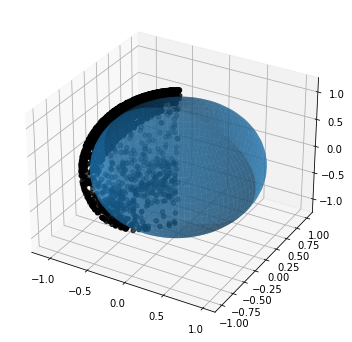

In [22]:
plot_angles(angles[:2000])

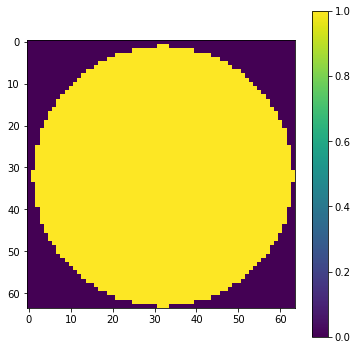

In [30]:
alpha = 1e-9
#alpha = 1e-6

#radius = 0.045 # for nx=32
radius = 0.0925
#radius = 1.6 # for nx=64
#radius = 3.2 # for nx=128)
mask = create_3d_mask(x_grid, (0,0,0),radius)
mip_z(jnp.fft.fftshift(mask)); plt.colorbar()
M = 1/jnp.max(sigma_noise)**2 * jnp.ones([nx, nx, nx])

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")

loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
grad_loss_volume, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)


logPi = lambda v : -loss_func_sum(v, angles, shifts, ctf_params, imgs_f, sigma_noise)
gradLogPi = lambda v : -jnp.conj(grad_loss_volume_sum(v, angles, shifts, ctf_params, imgs_f, sigma_noise))
#gradLogPi = lambda v : gradLogPi_split(v, angles_rec, shifts, ctf_params, imgs_f, sigma_noise, 10)


In [31]:
N_mc_samples = 21
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

#v0 = (jnp.array(np.random.randn(nx,nx,nx) + 1j * np.random.randn(nx,nx,nx)) )
v0 = jnp.zeros([nx,nx,nx])*1j
#v0 = v_rec
proposal_params_mala = {"tau" : 0.005}

dt_list = jnp.array([0.1, 0.5, 5, 10])
#dt_list = jnp.array([5])
proposal_params_hmc = {"dt_list" : dt_list, "L" : 10, "M" : M, "gradLogPi" : gradLogPi}

v_hmc_mean, r_hmc, v_hmc_samples = mcmc(key, N_mc_samples, proposal_hmc, logPi, v0, proposal_params_hmc)

  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 2003.2684625283466


0.8500000000000001


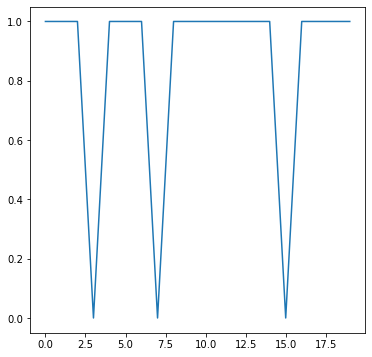

In [32]:
print(jnp.mean(r_hmc))
plt.plot(r_hmc)

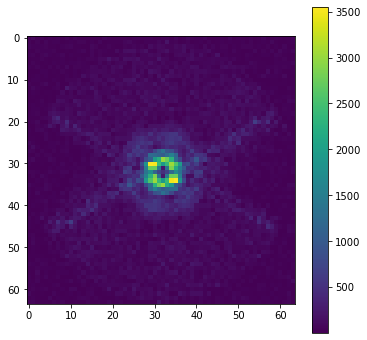

In [33]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_hmc_samples[N_mc_samples-2,:,:,0]))); plt.colorbar()

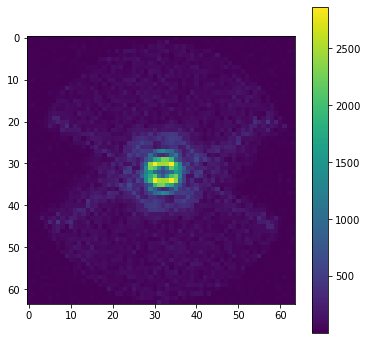

In [34]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_hmc_mean[:,:,0]))); plt.colorbar()

In [ ]:
#plt.imshow(jnp.abs(jnp.fft.fftshift(v_rec[:,:,0]))); plt.colorbar()

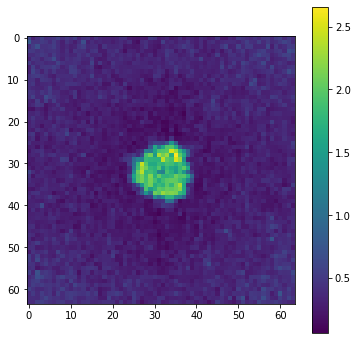

In [37]:
v_hmc_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_hmc_mean)))
mip_z(v_hmc_r)
plt.colorbar()

In [38]:
with mrcfile.new('../data/reconstruction_data_v_hmc_mean_list_10_1e-9_ar.mrc', overwrite=True) as mrc:
    mrc.set_data(v_hmc_r.astype(np.float32))

In [80]:
#import pickle
#file = open('../data/3dfsc64/angles_rec', 'wb')
#pickle.dump(angles_rec, file)
#file.close()

In [81]:
with open('../data/3dfsc64/angles_rec', 'rb') as file:
    # Call load method to deserialze
    angles_rec2 = pickle.load(file)

In [ ]:
#jnp.sum(jnp.abs(angles_rec2 - angles_rec))

### MCMC orientations

In [23]:
alpha0 = 0

radius = 0.4
mask = create_3d_mask(x_grid, (0,0,0),radius)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()

slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
loss_func0, loss_func_batched0, loss_func_sum0, _ = get_loss_funcs(slice_func, alpha = alpha0)
logPi_batch = lambda a : -loss_func_batched0(vol_fourier, a, shifts_true, ctf_params, imgs, 1)

### CG - choosing $\alpha$

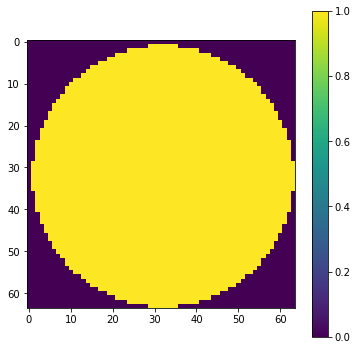

In [63]:
centre = (0,0,0)
#radius = 0.045
radius = 0.093
mask = create_3d_mask(x_grid, centre, radius)
mask2d = mask[:,:,0]

plt.imshow(jnp.fft.fftshift(mask2d)); plt.colorbar()

First, the slice function and the data fidelity function (i.e. the loss function with $\alpha=0$):

In [64]:
slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
fid_func, fid_func_batched, fid_func_sum, _ = get_loss_funcs(slice_func, alpha = 0)

The noise

sigma noise min = 296.94659423828125
sigma noise max = 960.4550170898438
sigma noise mean = 392.459730476141


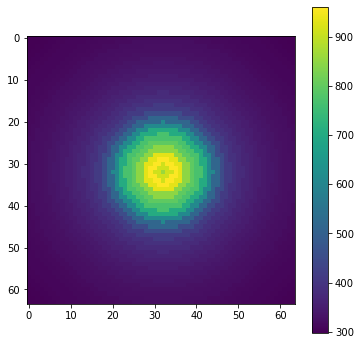

In [65]:
print("sigma noise min =", jnp.min(sigma_noise))
print("sigma noise max =", jnp.max(sigma_noise))
print("sigma noise mean =", jnp.mean(sigma_noise))

#sigma_noise = jnp.max(sigma_noise)*jnp.ones(sigma_noise.shape)
plt.imshow(jnp.fft.fftshift(sigma_noise.reshape([nx,nx]))); plt.colorbar()

In [232]:
imgs_f_m = imgs_f * mask2d.reshape(-1)

In [292]:
N_iter = 50100
eps = 1e-4
#eps = 1e-5
#eps = 1e-3
#eps = 1e-6
v0 = jnp.zeros([nx,nx,nx])* 1j
#alphas = [1.1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
#alphas = [1e-10, 1e-9, 1e-8]
alphas = [1e-8]
vcgs = []
fids = []
regs = []
losss = []
angles_cg = angles

In [293]:
N_alpha = len(alphas)
for alpha in alphas[:N_alpha]:
    t0 = time.time()
    print('alpha =', alpha)
    
    loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
    grad_loss_volume, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)
    
    AA, Ab = get_cg_vol_ops(grad_loss_volume_sum, angles_cg, shifts, ctf_params, imgs_f_m, v0.shape, sigma_noise)
    vcg, _ = conjugate_gradient(AA, Ab, v0, N_iter, eps, verbose = True)
    
    fid = 2*fid_func_sum(vcg, angles_cg, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    reg = l2sq(vcg)/(nx*nx*nx)
    loss = loss_func_sum(vcg, angles_cg, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    
    vcgs.append(vcg)
    fids.append(fid)
    regs.append(reg)
    losss.append(loss)
    
    print("  fid =", fid)
    print("  reg =", reg)
    print("  loss =", loss)
    
    print("  Time =", time.time() - t0)
    
vcgs = jnp.array(vcgs)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

alpha = 1e-08
  cg iter 0 ||r|| = 0.0006530734857003482
  cg iter 50 ||r|| = 0.00036271066470436704
  cg iter 100 ||r|| = 0.0002448028276882383
  cg iter 150 ||r|| = 0.0001800771396830169
  cg iter 200 ||r|| = 0.00016214331007955086
  cg iter 250 ||r|| = 0.0001482164640101242
  cg iter 300 ||r|| = 0.00011204845827430622
  cg iter 350 ||r|| = 0.00015081597072255737
  cg iter 400 ||r|| = 0.00012536157464779112
  cg iter 450 ||r|| = 0.00011103298297622021
  cg iter 492 ||r|| = 9.988624749711148e-05
  fid = 11.919841723923643
  reg = 27817612.264153592
  loss = 10.410738824226396
  Time = 131.3923945426941


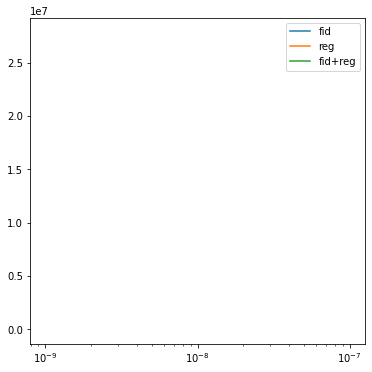

In [294]:
plt.semilogx(alphas, fids)
plt.semilogx(alphas, regs)
plt.semilogx(alphas, losss)
plt.legend(['fid', 'reg', 'fid+reg'])

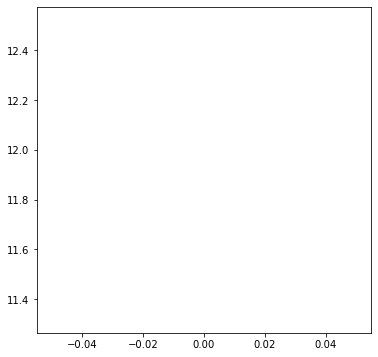

In [295]:
plt.plot(fids)

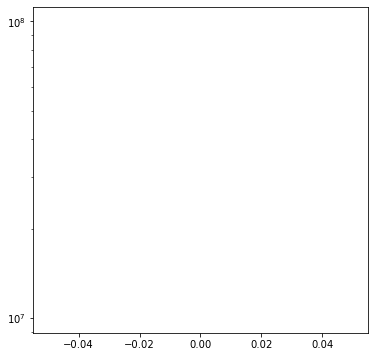

In [296]:
plt.semilogy(regs)

Pixel-wise loss for the best reconstruction:

In [297]:
mask.shape

(32, 32, 32)

In [50]:
def pixel_wise_fid_fun(v, slice_func_array, angles, shifts, ctf_params, imgs, sigma):
    err = slice_func_array(v, angles, shifts, ctf_params) - imgs
    return jnp.mean(jnp.real(jnp.conj(err)*err), axis = 0)/(2*sigma**2)
    #return jnp.mean(jnp.real(jnp.conj(err)*err), axis = 0)/2

In [299]:
alphas[alpha_idx]

DeviceArray(1.e-08, dtype=float64)

In [300]:
sigma_noise1 = jnp.ones(sigma_noise.shape)

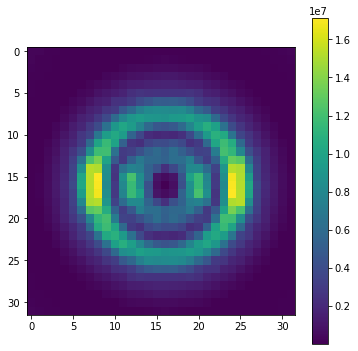

In [301]:
pw_fid = pixel_wise_fid_fun(vcgs[0], slice_func_array, angles, shifts, ctf_params, imgs_f_m, sigma_noise1)
plt.imshow(jnp.fft.fftshift(pw_fid.reshape([nx,nx]))); plt.colorbar()

Pixel-wise loss for the ZERO volume:

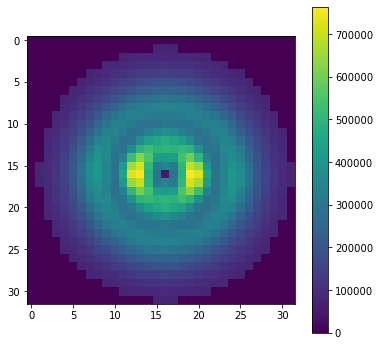

In [302]:
pw_fid0 = pixel_wise_fid_fun(jnp.zeros(v0.shape), slice_func_array, angles_rec, shifts, ctf_params, imgs_f_m, sigma_noise1)
plt.imshow(jnp.fft.fftshift(pw_fid0.reshape([nx,nx]))); plt.colorbar()

In [303]:
alpha_idx = jnp.argmin(fids)
print(alpha_idx)

0


In [304]:
#alpha_idx = 2

1e-08


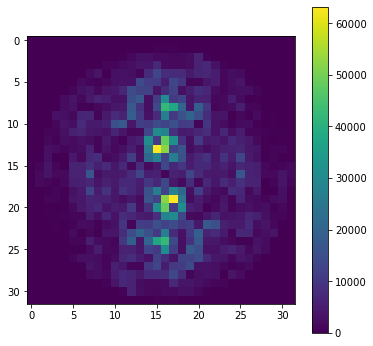

In [305]:
print(alphas[alpha_idx])
plt.imshow(jnp.abs(jnp.fft.fftshift(vcgs[alpha_idx][:,0,:]))); plt.colorbar()

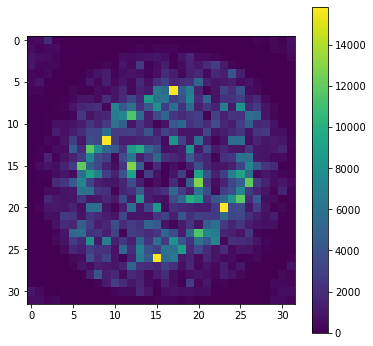

In [306]:
img_idx = 100
s0 = slice_func(vcgs[alpha_idx], angles_cg[img_idx], shifts[img_idx], ctf_params[img_idx])
plt.imshow(jnp.fft.fftshift(jnp.abs(s0).reshape(nx,nx))); plt.colorbar()

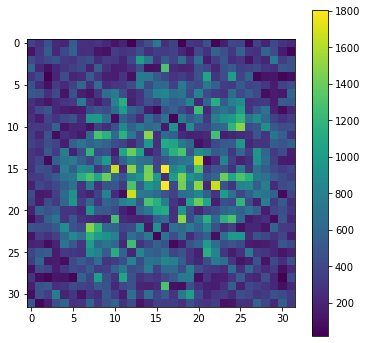

In [307]:
plt.imshow(jnp.fft.fftshift(jnp.abs(imgs_f[img_idx]).reshape(nx,nx))); plt.colorbar()

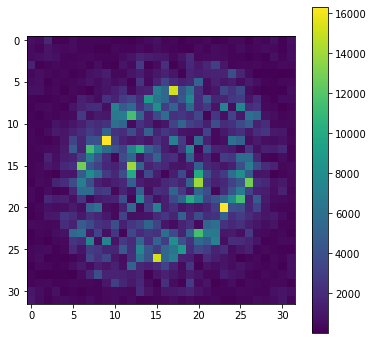

In [308]:
plt.imshow(jnp.fft.fftshift(jnp.abs(s0 - imgs_f[img_idx]).reshape(nx,nx))); plt.colorbar()

Text(0.5, 1.0, 'Reconstruction MIP')

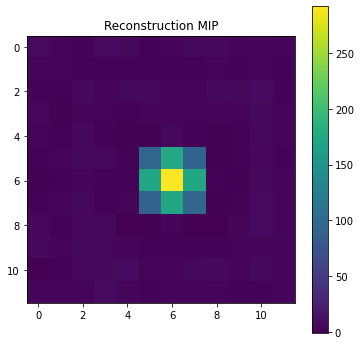

In [309]:
vr_rec = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))
mip_z(vr_rec)
plt.colorbar()
plt.title('Reconstruction MIP')

Text(0.5, 1.0, 'Reconstruction MIP')

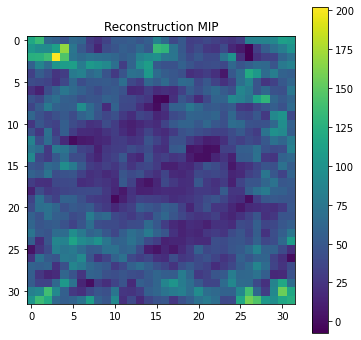

In [310]:
vcg_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vcgs[alpha_idx])))
mip_z(vcg_r)
plt.colorbar()
plt.title('Reconstruction MIP')


In [ ]:
with mrcfile.new('../data/reconstruction_data_32_cg_alpha.mrc', overwrite=True) as mrc:
    mrc.set_data(vcg_r.astype(np.float32))

### All images are the same, with different scalings (corresponding to different orders of $\alpha$)

In [94]:
vcgs_s = vcgs[:,:,0,0]
vcgs_s.shape

(10, 32)

In [311]:
plt.plot(jnp.abs(vcgs_s[0]))
plt.plot(jnp.abs(vcgs_s[1])*9)
plt.plot(jnp.abs(vcgs_s[2])*90)
plt.plot(jnp.abs(vcgs_s[3])*900)
plt.plot(jnp.abs(vcgs_s[6])*9e5)
plt.plot(jnp.abs(vcgs_s[8])*9e7)
plt.plot(jnp.abs(vcgs_s[10])*9e8)

NameError: name 'vcgs_s' is not defined

### FSC, orientations, standard deviation for each voxel etc

In [312]:
vcg1 = vcgs[0]
vcg2 = vcgs[6]

In [313]:
res, fsc, shell_points = calc_fsc(vcg1, vcg2, x_grid)

In [315]:
points_v_tri = points_orientations_tri(angles, x_grid[1].astype(jnp.int64), number_of_batches = 1000)
#points_v_nn = points_orientations_nn(angles[:1000], x_grid[1])

Rotating coordinates
Finding point indices
Splitting in batches.
Adding up number of points from batches.


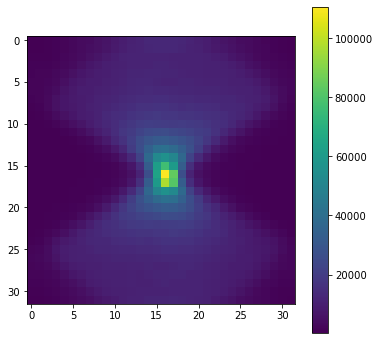

In [316]:
plt.imshow(jnp.fft.fftshift(points_v_tri[:,:,0])); plt.colorbar()

In [317]:
res_spu, spu_tri = shell_points_used(points_v_tri, x_grid)

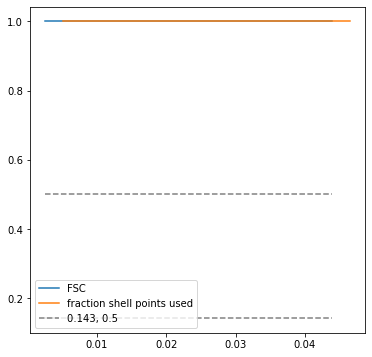

In [318]:
plt.plot(res, fsc)
plt.plot(res_spu, spu_tri)
plt.hlines([0.143, 0.5], xmin=min(res), xmax=max(res), colors = ['gray'], linestyles=['dashed'])
plt.legend(['FSC', 'fraction shell points used', '0.143, 0.5'])
#plt.title('Clustered angles')

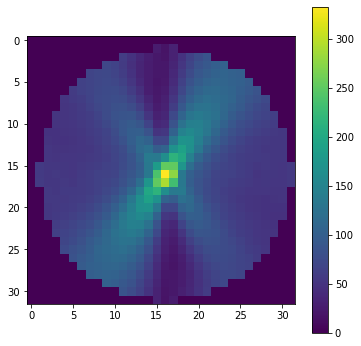

In [319]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[0,:,:]*mask[0,:,:]))))); plt.colorbar()

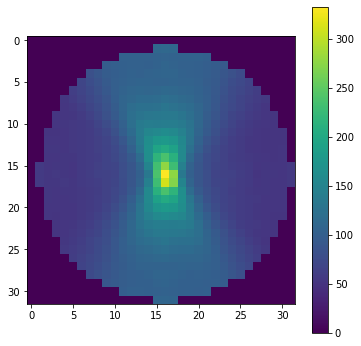

In [320]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,0,:]*mask[:,0,:]))))); plt.colorbar()

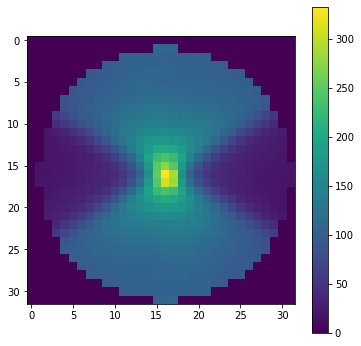

In [321]:
plt.imshow((jnp.sqrt(jnp.abs(jnp.fft.fftshift(points_v_tri[:,:,0]*mask[:,:,0]))))); plt.colorbar()

In [322]:
vones = jnp.ones(vcg1.shape)
omega = AA(vones)
omega = 1/omega

In [323]:
jnp.min(jnp.abs(omega))

DeviceArray(21356.67557362, dtype=float64)

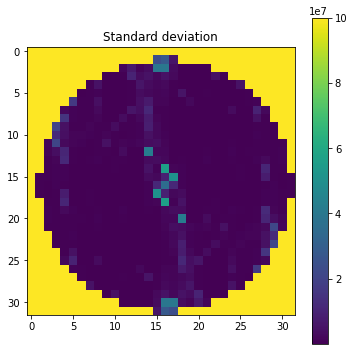

In [324]:
plt.title("Standard deviation")
plt.imshow(jnp.abs(jnp.fft.fftshift(omega[0,:,:]))); plt.colorbar()

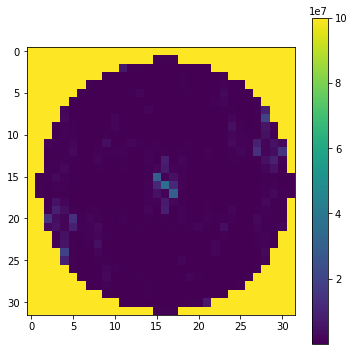

In [325]:
plt.imshow(jnp.abs(jnp.fft.fftshift(omega[:,0,:]))); plt.colorbar()

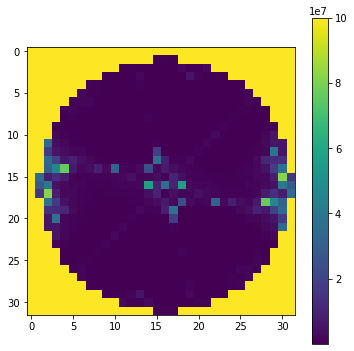

In [326]:
plt.imshow(jnp.abs(jnp.fft.fftshift(omega[:,:,0]))); plt.colorbar()

### SGD

### Preconditioner

1e-06
1.000001
1e-06


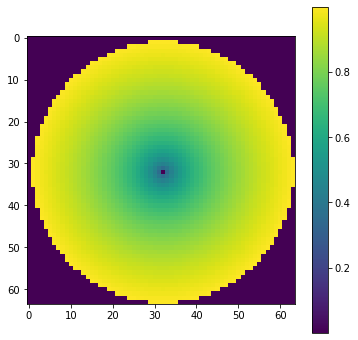

In [39]:
P = get_preconditioner(x_grid) * mask
#P = jnp.sqrt(P) /jnp.max(P) + 1e-6
#P = jnp.sqrt(P)
P = P**0.15
P = P /jnp.max(P)+ 1e-6
plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))
print(jnp.min(P))

### Points/orientations preconditioner

In [40]:
P = points_v_tri +1
P = 1/P * mask + 1e-12
P = P/jnp.max(P) * mask
plt.imshow(jnp.fft.fftshift(P[:,:,0]));plt.colorbar()
print(P[0,0,0])
print(jnp.max(P))
print(jnp.min(P))

NameError: name 'points_v_tri' is not defined

### $\alpha$ tuning

In [42]:
mask2d = mask[:,:,0]
imgs_f_m = imgs_f * mask2d.reshape(-1)

In [43]:
N_epoch = 501000
batch_size = 300
#learning_rate = 100000
learning_rate = 10000 * 100
#learning_rate = 10000 # for "large" alpha

P = None

#eps = 3e-5
#eps = 1e-3
#eps = 1e-9
eps = 1e-8
v0 = jnp.zeros([nx,nx,nx])* 1j
#alphas = 1/100 * jnp.array([1e-9, 1e-8, 1e-7, 1.1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]) #, 1e0, 1e1, 1e2, 1e3]
#alphas = [1e-10, 1e-9, 1e-8, 1e-7]
alphas = [1e-9]

angles_gd = angles

In [66]:
vgds = []
fids = []
regs = []
losss = []

#N_alpha = 4
for alpha in alphas:
    t0 = time.time()
    print('alpha =', alpha)
    
    slice_func,slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
    loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)

    grad_loss_volume, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

    sgd_grad_func = get_sgd_vol_ops(grad_loss_volume_sum, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)
    
    vgd = sgd(sgd_grad_func, N, v0, learning_rate, N_epoch, batch_size, P, eps, verbose = True)
    
    fid = 2*fid_func_sum(vgd, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    reg = l2sq(vgd)/(nx*nx*nx)
    loss = loss_func_sum(vgd, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)/(nx*nx)
    
    vgds.append(vgd)
    fids.append(fid)
    regs.append(reg)
    losss.append(loss)
    
    print("  fid =", fid)
    print("  reg =", reg)
    print("  loss =", loss)
    
    print("  Time =", time.time() - t0)
    
vgds = jnp.array(vgds)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

alpha = 1e-09
  sgd epoch 0: mean gradient = 2.4416222429832636e-08
  sgd epoch 10: mean gradient = 2.229483749016131e-09
  fid = 0.7217584520857653
  reg = 7174.638502993368
  loss = 0.36110881447497845
  Time = 32.498202323913574


In [67]:
vgds = jnp.array(vgds)
fids = jnp.array(fids)
regs = jnp.array(regs)
losss = jnp.array(losss)
alphas = jnp.array(alphas)

alpha_idx = jnp.argmin(fids)

N_alpha= len(fids)

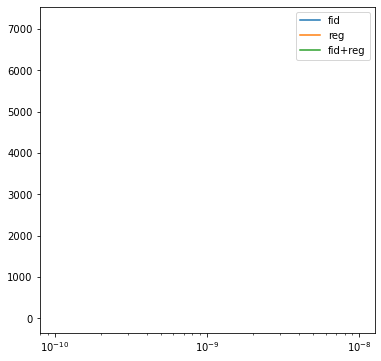

In [68]:
plt.semilogx(alphas[:N_alpha], fids)
plt.semilogx(alphas[:N_alpha], regs)
plt.semilogx(alphas[:N_alpha], losss)
plt.legend(['fid', 'reg', 'fid+reg'])

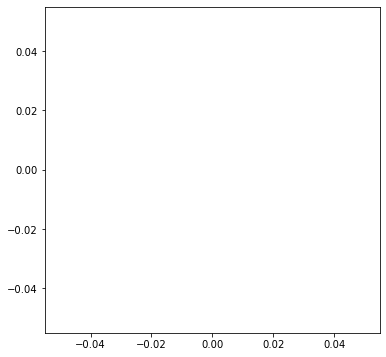

In [55]:
plt.plot(fids)

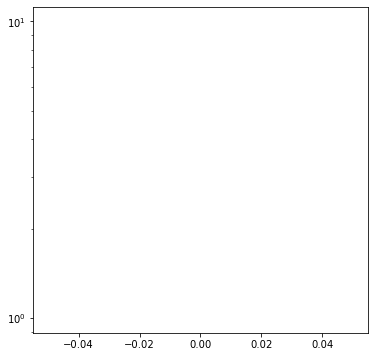

In [56]:
plt.semilogy(regs)

In [57]:
alphas[2]

DeviceArray(1.e-09, dtype=float64)

In [58]:
#alpha_idx= 3
#alpha_idx=5
#alpha_idx=0

0.6953319373768474


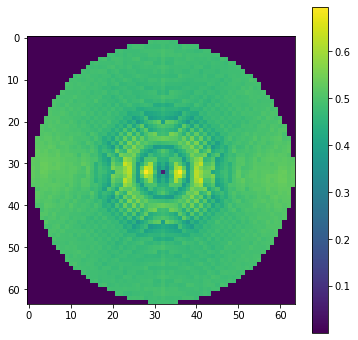

In [69]:
pw_fid = pixel_wise_fid_fun(vgds[alpha_idx], slice_func_array, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid.reshape([nx,nx]))); plt.colorbar()
print(jnp.max(pw_fid))

0.6953319373768474


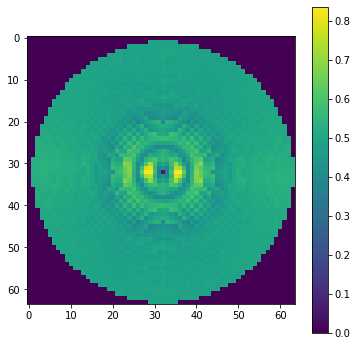

In [70]:
pw_fid0 = pixel_wise_fid_fun(jnp.zeros(vgd.shape), slice_func_array, angles_gd, shifts, ctf_params, imgs_f_m, sigma_noise)
plt.imshow(jnp.fft.fftshift(pw_fid0.reshape([nx,nx]))); plt.colorbar()
print(jnp.max(pw_fid))

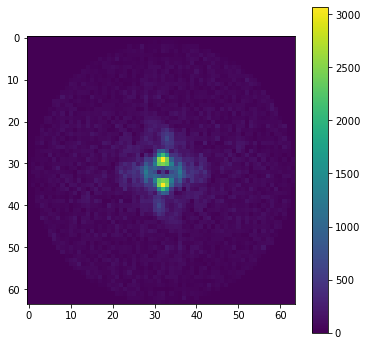

In [71]:
plt.imshow(jnp.fft.fftshift(jnp.abs(vgds[alpha_idx,:,0,:]))); plt.colorbar()

In [72]:
#plt.imshow(jnp.fft.fftshift(jnp.abs(v_rec[:,0,:]))); plt.colorbar()

In [344]:
#err = vgds[1] - v_rec
#plt.imshow(jnp.fft.fftshift((jnp.abs(err[:,0,:]))*mask[:,0,:])); plt.colorbar()

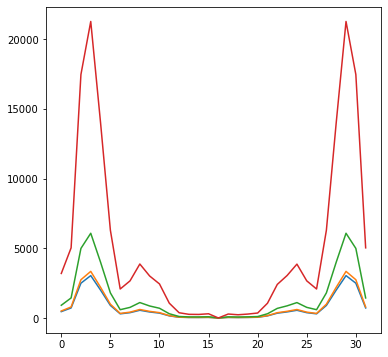

In [345]:
vgds_s = vgds[:,:,0,0]
vgds_s.shape

plt.plot(jnp.abs(vgds_s[0]))
plt.plot(jnp.abs(vgds_s[1])*1.1)
plt.plot(jnp.abs(vgds_s[2])*2)
plt.plot(jnp.abs(vgds_s[3])*7)


Text(0.5, 1.0, 'Reconstruction MIP')

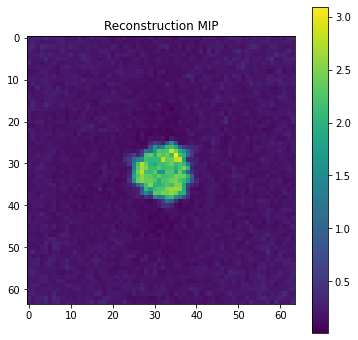

In [73]:
vr_sgd = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(vgds[alpha_idx])))
mip_z(vr_sgd)
plt.colorbar()
plt.title('Reconstruction MIP')

In [74]:
vr_rec = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))
mip_z(vr_rec)
plt.colorbar()
plt.title('Reconstruction MIP')

NameError: name 'v_rec' is not defined

In [76]:
with mrcfile.new('../data/reconstruction_data_32_sgd_alpha.mrc', overwrite=True) as mrc:
    mrc.set_data(vr_sgd.astype(np.float32))

In [77]:
idx = 100

In [78]:
slicegd = slice_func(vgds[alpha_idx], angles_gd[idx], shifts[idx], ctf_params[idx])
#slicerec = slice_func(v_rec, angles_gd[idx], shifts[idx], ctf_params[idx])

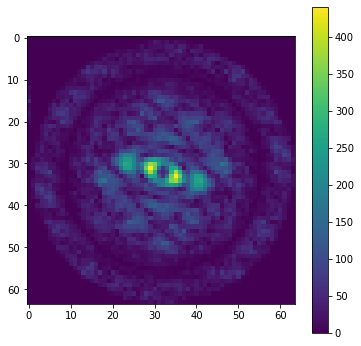

In [81]:
plt.imshow(jnp.abs(jnp.fft.fftshift(slicegd.reshape([nx,nx])))); plt.colorbar()

In [ ]:
#plt.imshow(jnp.abs(jnp.fft.fftshift(slicerec.reshape([32,32])))); plt.colorbar()

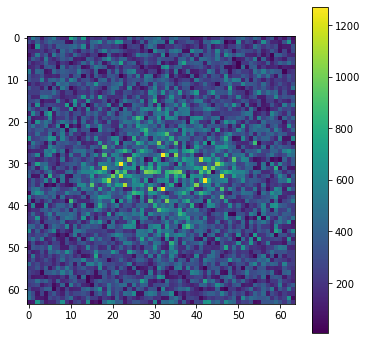

In [82]:
plt.imshow(jnp.abs(jnp.fft.fftshift(imgs_f[idx].reshape([nx,nx])))); plt.colorbar()

### Volume residual

In [102]:
angles_rec = angles #angles_rec2

In [103]:
alpha = 1e-9
N_train = 3000

radius = 0.0925
mask = create_3d_mask(x_grid, (0,0,0),radius)
#mip_z(jnp.fft.fftshift(mask)); plt.colorbar()
M = 1/jnp.max(sigma_noise)**2 * jnp.ones([nx, nx, nx])

slice_func, slice_func_array, slice_func_array_angles = get_slice_funcs(project, x_grid, mask, "tri")
loss_func, loss_func_batched, loss_func_sum, _ = get_loss_funcs(slice_func, alpha = alpha)
grad_loss_volume, grad_loss_volume_sum = get_grad_v_funcs(loss_func, loss_func_sum)

logPi = lambda v : -loss_func_sum(v, angles_rec[:N_train], shifts[:N_train], ctf_params[:N_train], imgs_f[:N_train], sigma_noise)
gradLogPi = lambda v : -jnp.conj(grad_loss_volume_sum(v, angles_rec[:N_train], shifts[:N_train], ctf_params[:N_train], imgs_f[:N_train], sigma_noise))

In [104]:
N_mc_samples = 101
key = random.PRNGKey(int(jnp.floor(np.random.rand()*1000)))

v0 = jnp.zeros([nx,nx,nx])*1j
dt_list = jnp.array([0.01, 0.1, 0.5, 5, 10])
proposal_params_hmc = {"dt_list" : dt_list, "L" : 10, "M" : M, "gradLogPi" : gradLogPi}

v_rec, r_hmc, v_hmc_samples = mcmc(key, N_mc_samples, proposal_hmc, logPi, v0, proposal_params_hmc)

  Iter 20 , a =  1.0
  MC sample 20 , loss (of mean) = 1996.6080303458466
  Iter 40 , a =  1.0
  MC sample 40 , loss (of mean) = 1992.7110296585097
  Iter 60 , a =  1.0
  MC sample 60 , loss (of mean) = 1991.4896242344516
  Iter 80 , a =  1.0
  MC sample 80 , loss (of mean) = 1991.0341465351066
  Iter 100 , a =  1.0
  MC sample 100 , loss (of mean) = 1990.7694906253714


0.729972229122042


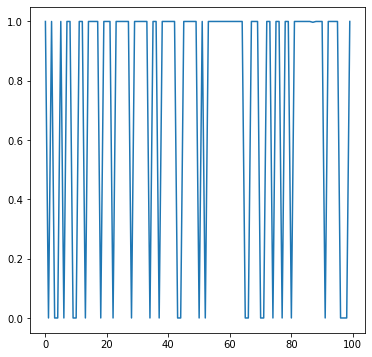

In [105]:
print(jnp.mean(r_hmc))
plt.plot(r_hmc)

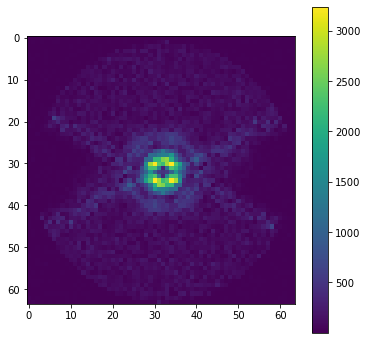

In [106]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_rec[:,:,0]))); plt.colorbar()

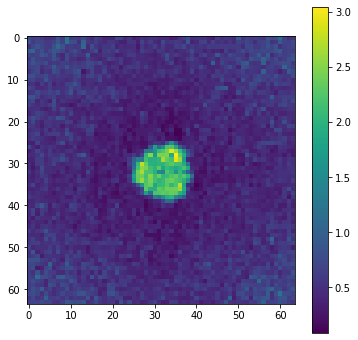

In [107]:
v_rec_r = jnp.real(jnp.fft.fftshift(jnp.fft.ifftn(v_rec)))
mip_z(v_rec_r)
plt.colorbar()

In [108]:
with mrcfile.new('../data/3dfsc/v_rec_vol_hmc.mrc', overwrite=True) as mrc:
    mrc.set_data(v_rec_r.astype(np.float32))

In [109]:
N_batches = 60000
v_resid = get_volume_residual(v_rec, angles_rec[N_train:5000], shifts[N_train:], ctf_params[N_train:], imgs_f[N_train:], x_grid, slice_func_array, N_batches)
                              

100%|██████████| 60000/60000 [02:06<00:00, 475.69it/s]


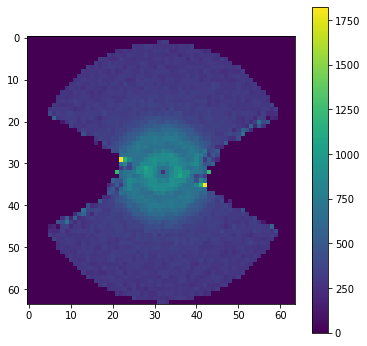

In [110]:
plt.imshow(jnp.abs(jnp.fft.fftshift(v_resid[:,:,0]*mask[:,:,0]))); plt.colorbar()

In [114]:
v_resid_print = jnp.fft.fftshift(v_resid*mask)
with mrcfile.new('../data/3dfsc/v_resid.mrc', overwrite=True) as mrc:
    mrc.set_data(v_resid_print.astype(np.float32))